In [1]:
import os
import os.path
import gc
import itertools
import numpy as np
import pandas as pd
import scipy.sparse
from tqdm import tqdm

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [4]:
sns.set()

In [5]:
import pickle

def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

## Read Data

In [6]:
%%time
DATA_DIR = '../input/open-problems-multimodal'
train_tar = pd.read_hdf(f'{DATA_DIR}/train_cite_targets.h5')
train_tar_cols = train_tar.columns

CPU times: user 225 ms, sys: 84.5 ms, total: 309 ms
Wall time: 840 ms


In [7]:
train_tar = train_tar.values

In [8]:
train_tar_cp = train_tar.copy()

In [9]:
train_tar -= train_tar.mean(axis=1).reshape(-1, 1)
train_tar /= train_tar.std(axis=1).reshape(-1, 1)
train_tar.shape

(70988, 140)

In [10]:
%%time
DATA_DIR = '../input/msci-citeseq-mlp-tsvd-if'
train_inp = load_pickle(f'{DATA_DIR}/train_inp')

CPU times: user 18.3 ms, sys: 80.7 ms, total: 99 ms
Wall time: 419 ms


In [11]:
train_inp = train_inp[:, :-1]
train_inp.shape

(70988, 148)

## Modeling

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold

## Dataset & DataLoader

In [13]:
kf = KFold(n_splits=5)
kf.get_n_splits(train_inp)

5

In [14]:
folds = [[train_index, val_index]
         for train_index, val_index in kf.split(train_inp)]

In [15]:
def set_up_data_loader(fold,
                       train_inp=train_inp,
                       train_tar=train_tar):
    train_index, val_index = fold
    
    # Train
    train_ds = TensorDataset(torch.from_numpy(train_inp[train_index]),
                             torch.from_numpy(train_tar[train_index]))
    
    # Val
    val_ds = TensorDataset(torch.from_numpy(train_inp[val_index]),
                             torch.from_numpy(train_tar[val_index]))
    
    # Set up dataloader
    batch_size = 512
    train_loader = DataLoader(train_ds, 
                              batch_size=batch_size, 
                              shuffle=True)
    val_loader = DataLoader(val_ds, 
                            batch_size=batch_size, 
                            shuffle=False)
    
    return train_loader, val_loader

### Define NN

In [16]:
class Net(nn.Module):
    def __init__(self):
        """In the constructor we instantiate two nn.Linear modules and assign them as
        member variables (self).
        """
        super(Net, self).__init__()
#         self.linear1 = nn.Linear(663, 128*2)
        self.linear1 = nn.Linear(148, 128*2)
        self.selu1 = nn.SELU(128*2)
        self.linear2 = nn.Linear(128*2, 128*2)
        self.selu2 = nn.SELU(128*2)
        self.linear3 = nn.Linear(128*2, 128*2)
        self.selu3 = nn.SELU(128*2)
        self.linear4 = nn.Linear(128*2, 140)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = self.selu1(x)
        x = self.linear2(x)
        x = self.selu2(x)
        x = self.linear3(x)
        x = self.selu3(x)
        x = self.linear4(x)
        return x

### Find LR

In [17]:
def find_lr(model, train_loader, optimizer,
            init_val=1e-8, final_val=10.0, beta=0.98):
    # https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate
    
    num = len(train_loader)
    mult = (final_val / init_val) ** (1 / num)
    lr = init_val
    optimizer.param_groups[0]['lr'] = lr
    
    avg_loss = 0
    best_loss = 0
    batch_num = 0
    smoothed_losses = []
    raw_losses = []
    log_lrs = []
    
    for i, (x, y) in enumerate(train_loader):
        batch_num+=1
        batch = x.shape[0]
        
        optimizer.zero_grad()
        
        # Prediction
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        loss_cpu = float(loss.detach().numpy())
        
        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1 - beta) * loss_cpu
        smoothed_loss = avg_loss / (1 - beta ** batch_num)
        
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
            
        raw_losses.append(loss_cpu)
        smoothed_losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))
        
        loss.backward()
        optimizer.step()
        
        # Update the lr for the next batch
        lr*=mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, raw_losses, smoothed_losses

In [18]:
def find_lr_for_one_fold(fold, 
                         train_inp=train_inp,
                         train_tar=train_tar):
    # Set up dataloader
    train_loader, val_loader = set_up_data_loader(fold,
                                                  train_inp=train_inp,
                                                  train_tar=train_tar)
    
    weight_decays = [0.01, 0.001, 0.0001, 0.00001]
    res = {}

    for weight_decay in weight_decays:
        net = Net()
        optimizer = optim.Adam(net.parameters(), 
                               weight_decay=weight_decay)
        log_lrs, raw_losses, smoothed_losses = find_lr(net, 
                                                       train_loader, 
                                                       optimizer)

        # Find steepest gradient according to fast.ai
        # https://fastai1.fast.ai/callbacks.lr_finder.html
        gradients = np.gradient(raw_losses)
        min_gradient = gradients.min()
        for i in range(len(raw_losses)):
            if gradients[i] == min_gradient:
                print(f'weight decay: {weight_decay}')
                print(f'learning rate w/ steepest gradient {log_lrs[i]:.4f}')
                print()
                break

        res[weight_decay] = {
            'log lrs': log_lrs,
            'raw losses': raw_losses,
            'smoothed losses': smoothed_losses
        }
        
    return res

In [19]:
def plot_find_lr(res, cutoff):
    weight_decays = [0.01, 0.001, 0.0001, 0.00001]
    
    plt.subplot(2, 1, 1)
    for weight_decay in weight_decays:
        plt.plot(res[weight_decay]['log lrs'], 
                 res[weight_decay]['raw losses'],
                 label=f'wd={weight_decay}')
    plt.vlines(cutoff, -0.9, 0.1, linestyles='--', colors='black')
    plt.legend()
    plt.title('raw losses')

    plt.subplot(2, 1, 2)
    for weight_decay in weight_decays:
        plt.plot(res[weight_decay]['log lrs'], 
                 res[weight_decay]['smoothed losses'],
                 label=weight_decay)
    plt.legend()
    plt.title('smoothed losses')

    plt.tight_layout()

In [20]:
%%time
folds_find_lr_res_dict = {i: find_lr_for_one_fold(folds[i])
                          for i in range(len(folds))}

weight decay: 0.01
learning rate w/ steepest gradient -0.7027

weight decay: 0.001
learning rate w/ steepest gradient -1.5135

weight decay: 0.0001
learning rate w/ steepest gradient -1.1081

weight decay: 1e-05
learning rate w/ steepest gradient -1.4324

weight decay: 0.01
learning rate w/ steepest gradient -0.9459

weight decay: 0.001
learning rate w/ steepest gradient 0.9189

weight decay: 0.0001
learning rate w/ steepest gradient -1.3514

weight decay: 1e-05
learning rate w/ steepest gradient -1.0270

weight decay: 0.01
learning rate w/ steepest gradient -0.7027

weight decay: 0.001
learning rate w/ steepest gradient -1.2703

weight decay: 0.0001
learning rate w/ steepest gradient -1.5135

weight decay: 1e-05
learning rate w/ steepest gradient -1.1892

weight decay: 0.01
learning rate w/ steepest gradient -1.1081

weight decay: 0.001
learning rate w/ steepest gradient -1.1081

weight decay: 0.0001
learning rate w/ steepest gradient -1.2703

weight decay: 1e-05
learning rate w/ stee

#### Fold 0

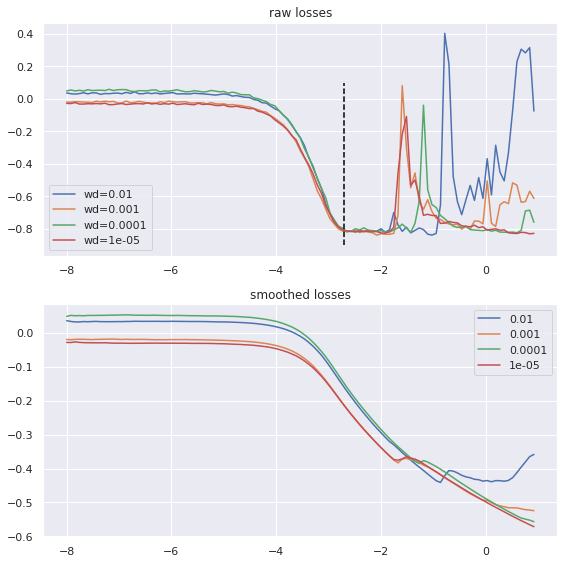

In [21]:
figsize(8, 8)
plot_find_lr(folds_find_lr_res_dict[0], -2.7)

#### Fold 1

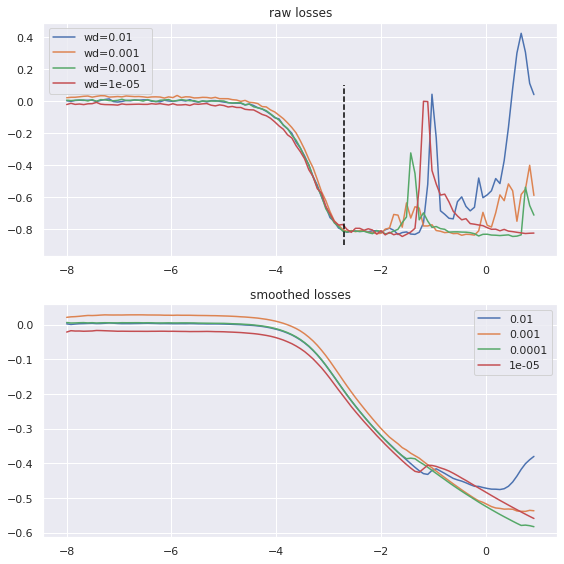

In [22]:
figsize(8, 8)
plot_find_lr(folds_find_lr_res_dict[1], -2.7)

#### Fold 2

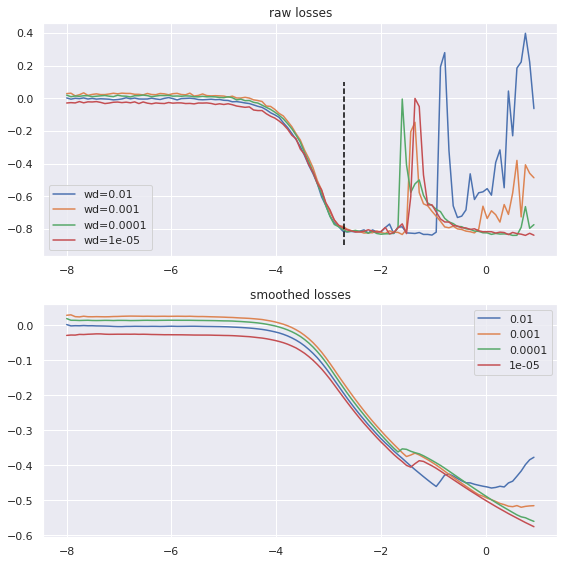

In [23]:
figsize(8, 8)
plot_find_lr(folds_find_lr_res_dict[2], -2.7)

#### Fold 3

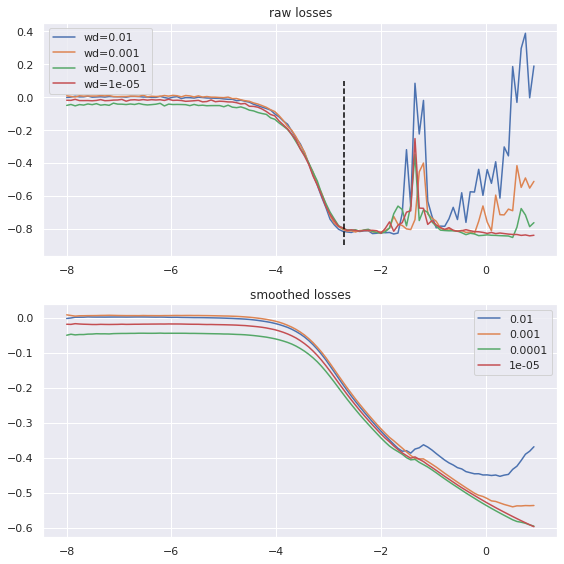

In [24]:
figsize(8, 8)
plot_find_lr(folds_find_lr_res_dict[3], -2.7)

#### Fold 4

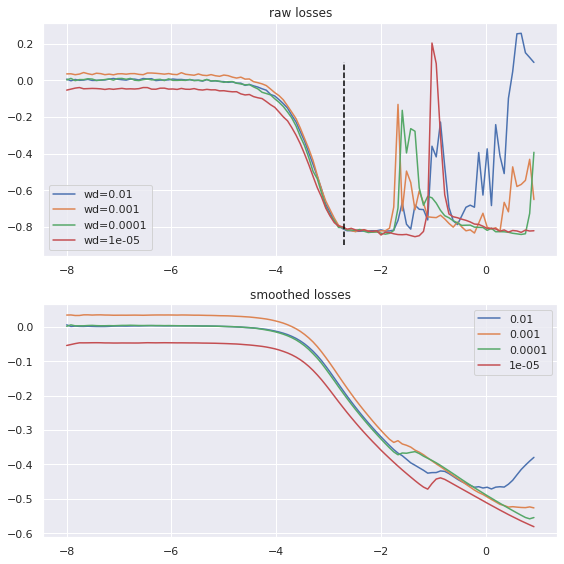

In [25]:
figsize(8, 8)
plot_find_lr(folds_find_lr_res_dict[4], -2.7)

### Train

In [26]:
def train_model(train_loader, model, optimizer, scheduler):
    
    model.train()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    lrs = []
    
    for i, (x, y) in enumerate(train_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
        
        total += batch
        sum_corr += batch * corr
    
    train_corr = sum_corr/total 
    return train_corr, lrs

In [27]:
def model_eval(model, val_loader):
    model.eval()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(val_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        total += batch
        sum_corr += batch * corr
        
    val_corr = sum_corr/total
    return val_corr

In [28]:
def train_one_fold(fold, max_lr, weight_decay, epochs,
                   train_inp=train_inp, train_tar=train_tar):
    # Set up dataloader
    train_loader, val_loader = set_up_data_loader(fold,
                                                  train_inp=train_inp,
                                                  train_tar=train_tar)
    
    # Set up model
    net = Net()

    # Set up optimizer & scheduler
    optimizer = optim.Adam(net.parameters(),
                           weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler\
                     .OneCycleLR(optimizer, 
                                 max_lr=max_lr,
                                 steps_per_epoch=len(train_loader),
                                 epochs=epochs)
    
    # Train
    train_corrs = []
    val_corrs = []
    num_epochs_run = 0
    lrs = []
    
    for epoch in range(epochs):
        num_epochs_run += 1

        # train
        print('epoch', epoch)
        train_corr, epoch_lrs = train_model(train_loader, net, optimizer, scheduler)
        train_corr = float(train_corr.detach().numpy())
        train_corrs.append(train_corr)
        lrs.append(epoch_lrs)
        print(f'train corr: {train_corr:.4f}')

        # val
        val_corr = model_eval(net, val_loader)
        val_corr = float(val_corr.detach().numpy())
        val_corrs.append(val_corr)
        print(f'val corr: {val_corr:.4f}')
        print()
        
    return net, lrs, train_corrs[-1], val_corrs[-1]

In [29]:
10**(-2.7)

0.001995262314968879

In [30]:
%%time
max_lr = 0.002
weight_decay = 0.000001
epochs = 30
train_corrs = []
val_corrs = []

net_dict = {}

for idx in range(len(folds)):
    print(f'Start training fold {idx}...')
    print()

    net, _, train_corr, val_corr = train_one_fold(folds[idx], 
                                                  max_lr=max_lr, 
                                                  weight_decay=weight_decay, 
                                                  epochs=epochs)
    
    print(f'Fold {idx} done.')
    print()
    
    net_dict[idx] = net
    train_corrs.append(train_corr)
    val_corrs.append(val_corr)
    
print('CV Score')
print(f'Train Correlation: {np.mean(train_corrs):.4f}')
print(f'Val Correlation: {np.mean(val_corrs):.4f}')

Start training fold 0...

epoch 0
train corr: 0.6107
val corr: 0.8280

epoch 1
train corr: 0.8733
val corr: 0.8801

epoch 2
train corr: 0.8874
val corr: 0.8891

epoch 3
train corr: 0.8917
val corr: 0.8921

epoch 4
train corr: 0.8934
val corr: 0.8938

epoch 5
train corr: 0.8943
val corr: 0.8949

epoch 6
train corr: 0.8953
val corr: 0.8960

epoch 7
train corr: 0.8965
val corr: 0.8968

epoch 8
train corr: 0.8976
val corr: 0.8974

epoch 9
train corr: 0.8987
val corr: 0.8977

epoch 10
train corr: 0.8994
val corr: 0.8985

epoch 11
train corr: 0.9002
val corr: 0.8989

epoch 12
train corr: 0.9007
val corr: 0.8997

epoch 13
train corr: 0.9013
val corr: 0.8999

epoch 14
train corr: 0.9016
val corr: 0.9006

epoch 15
train corr: 0.9020
val corr: 0.9005

epoch 16
train corr: 0.9024
val corr: 0.9003

epoch 17
train corr: 0.9029
val corr: 0.9008

epoch 18
train corr: 0.9033
val corr: 0.9005

epoch 19
train corr: 0.9035
val corr: 0.9009

epoch 20
train corr: 0.9039
val corr: 0.9013

epoch 21
train cor

In [31]:
# del train_inp, train_tar
# gc.collect()

## CV (In case Y gets standardized)

In [32]:
def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

In [33]:
%%time
cv_corrs = []

for i, fold in enumerate(folds):
    with torch.no_grad():
        net = net_dict[i]
        net.eval()
        val_set = torch.from_numpy(train_inp[fold[1]])
        preds = net(val_set).detach().numpy()
        corr = correlation_score(train_tar_cp[fold[1]], preds)
        print(f'fold {i}: {corr:.4f}')
        cv_corrs.append(corr)

print()
print(np.mean(cv_corrs))

fold 0: 0.9019
fold 1: 0.9015
fold 2: 0.9023
fold 3: 0.9055
fold 4: 0.8887

0.8999679441693302
CPU times: user 8.05 s, sys: 5.96 ms, total: 8.05 s
Wall time: 7.66 s


## Prediction

In [34]:
%%time
test_inp = load_pickle(f'{DATA_DIR}/test_inp')[:, :-1]
test_inp = torch.from_numpy(test_inp)

CPU times: user 7.96 ms, sys: 18.9 ms, total: 26.9 ms
Wall time: 501 ms


In [35]:
%%time
test_preds = []
with torch.no_grad():
    for net in net_dict.values():
        net.eval()
        test_preds.append(net(test_inp).detach().numpy())

CPU times: user 2.16 s, sys: 528 ms, total: 2.69 s
Wall time: 1.35 s


In [36]:
test_tar_preds = np.sum(test_preds, axis=0) / len(folds)
test_tar_preds.shape

(48663, 140)

In [37]:
del test_inp
gc.collect()

190

## Creating Submission

In [38]:
DATA_DIR = '../input/msci-h5-sparse-transform'
%ls $DATA_DIR -lh

total 7.1G
-rw-r--r-- 1 nobody nogroup  25K Nov 14 17:21 __notebook__.ipynb
-rw-r--r-- 1 nobody nogroup  25K Nov 14 17:21 __output__.json
-rw-r--r-- 1 nobody nogroup 293K Nov 14 17:21 __results__.html
-rw-r--r-- 1 nobody nogroup    0 Nov 14 17:21 custom.css
-rw-r--r-- 1 nobody nogroup 359M Nov 14 17:21 evaluation_ids.parquet
-rw-r--r-- 1 nobody nogroup 3.8M Nov 14 17:21 metadata.parquet
-rw-r--r-- 1 nobody nogroup 108K Nov 14 17:21 metadata_cite_day_2_donor_27678.parquet
-rw-r--r-- 1 nobody nogroup 252M Nov 14 17:21 sample_submission.parquet
-rw-r--r-- 1 nobody nogroup 856K Nov 14 17:21 test_cite_inputs_day_2_donor_27678_idx.npz
-rw-r--r-- 1 nobody nogroup  78M Nov 14 17:21 test_cite_inputs_day_2_donor_27678_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 1.8M Nov 14 17:21 test_cite_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 488M Nov 14 17:21 test_cite_inputs_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 8.4M Nov 14 17:21 test_multi_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 1.7G Nov 14 17:22 

In [39]:
test_tar_cols = np.load(f'{DATA_DIR}/train_cite_targets_idx.npz',
                        allow_pickle=True)['columns']
test_tar_idx = np.load(f'{DATA_DIR}/test_cite_inputs_idx.npz',
                       allow_pickle=True)['index']
test_tar_cols.shape, test_tar_idx.shape, test_tar_preds.shape

((140,), (48663,), (48663, 140))

In [40]:
%%time
print('Start Eval...')
eval_ids = pd.read_parquet(f'{DATA_DIR}/evaluation_ids.parquet')
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

Start Eval...
CPU times: user 30.9 s, sys: 10.1 s, total: 41 s
Wall time: 36.1 s


In [41]:
%%time
sub = pd.Series(name='target',
                index=pd.MultiIndex.from_frame(eval_ids), 
                dtype=np.float32)
sub

CPU times: user 19.4 s, sys: 3.67 s, total: 23.1 s
Wall time: 23.1 s


row_id    cell_id       gene_id        
0         c2150f55becb  CD86              NaN
1         c2150f55becb  CD274             NaN
2         c2150f55becb  CD270             NaN
3         c2150f55becb  CD155             NaN
4         c2150f55becb  CD112             NaN
                                           ..
65744175  2c53aa67933d  ENSG00000134419   NaN
65744176  2c53aa67933d  ENSG00000186862   NaN
65744177  2c53aa67933d  ENSG00000170959   NaN
65744178  2c53aa67933d  ENSG00000107874   NaN
65744179  2c53aa67933d  ENSG00000166012   NaN
Name: target, Length: 65744180, dtype: float32

In [42]:
cell_id_dict = {cell_id: idx 
                for idx, cell_id in enumerate(test_tar_idx, 0)}
gene_id_dict = {gene_id: idx 
                for idx, gene_id in enumerate(test_tar_cols, 0)}

In [43]:
eid_cid_idx = eval_ids['cell_id']\
              .apply(lambda x: cell_id_dict.get(x, -1))
eid_gid_idx = eval_ids['gene_id']\
              .apply(lambda x: gene_id_dict.get(x, -1))
valid_cite_rows = (eid_cid_idx != -1) & (eid_gid_idx != -1)

In [44]:
%%time
sub.iloc[valid_cite_rows] = test_tar_preds\
                             [eid_cid_idx[valid_cite_rows].to_numpy(),
                              eid_gid_idx[valid_cite_rows].to_numpy()]

CPU times: user 309 ms, sys: 159 ms, total: 468 ms
Wall time: 469 ms


In [45]:
del eval_ids, test_tar_idx, test_tar_cols
del eid_cid_idx, eid_gid_idx, valid_cite_rows
gc.collect() 

97

In [46]:
sub = pd.DataFrame(sub).fillna(0).reset_index()
sub.drop(['cell_id', 'gene_id'], axis=1)\
   .to_csv('cite_sub.csv', index=False)

In [47]:
sub.head()

,row_id,cell_id,gene_id,target
0,0,c2150f55becb,CD86,-0.904063
1,1,c2150f55becb,CD274,-0.882663
2,2,c2150f55becb,CD270,-0.683779
3,3,c2150f55becb,CD155,1.290424
4,4,c2150f55becb,CD112,1.934422
